<a href="https://colab.research.google.com/github/mayasrikanth/CS-236G-Project/blob/main/Personal_Copy_of_Katherine_Crowson's_Text_to_Image_(CC12M_Diffusion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generates images from text prompts.

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses a 602M parameter diffusion model trained on Conceptual 12M. See the GitHub repo for more information: https://github.com/crowsonkb/v-diffusion-pytorch.

In [ ]:
# @title Licensed under the MIT License

# Copyright (c) 2022 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [1]:
# Check the GPU

!nvidia-smi

Sun Feb 27 17:32:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies (no need to rerun this section if you restart the notebook runtime)

In [2]:
# Install dependencies

!pip install ftfy regex requests tqdm
!git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch

     |████████████████████████████████| 53 kB 1.3 MB/s 
Cloning into 'v-diffusion-pytorch'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 121 (delta 62), reused 64 (delta 33), pack-reused 26
Receiving objects: 100% (121/121), 32.89 KiB | 1.93 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Submodule 'CLIP' (https://github.com/openai/CLIP) registered for path 'CLIP'
Cloning into '/content/v-diffusion-pytorch/CLIP'...
remote: Enumerating objects: 195, done.        
remote: Counting objects: 100% (27/27), done.        
remote: Compressing objects: 100% (14/14), done.        
remote: Total 195 (delta 12), reused 22 (delta 9), pack-reused 168        
Receiving objects: 100% (195/195), 8.91 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (92/92), done.
Submodule path 'CLIP': checked out '40f5484c1c74edd83cb9cf687c6ab92b28d8b656'


In [3]:
# Download the diffusion model
# SHA-256: 4fc95ee1b3205a3f7422a07746383776e1dbc367eaf06a5b658ad351e77b7bda

!mkdir v-diffusion-pytorch/checkpoints
!curl -L https://v-diffusion.s3.us-west-2.amazonaws.com/cc12m_1_cfg.pth > v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2300M  100 2300M    0     0  47.4M      0  0:00:48  0:00:48 --:--:-- 49.0M


### Import modules and load models

In [4]:
# Imports

import gc
import math
import sys

from IPython import display
import torch
from torchvision import utils as tv_utils
from torchvision.transforms import functional as TF
from tqdm.notebook import trange, tqdm

sys.path.append('/content/v-diffusion-pytorch')

from CLIP import clip
from diffusion import get_model, sampling, utils

In [5]:
# Load the models

model = get_model('cc12m_1_cfg')()
_, side_y, side_x = model.shape
model.load_state_dict(torch.load('v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth', map_location='cpu'))
model = model.half().cuda().eval().requires_grad_(False)
clip_model = clip.load(model.clip_model, jit=False, device='cpu')[0]

100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 89.2MiB/s]


In [27]:
#@title Settings

#@markdown The text prompt
prompt = 'on a mountain top at sunrise with pink skies'  #@param {type:"string"}

#@markdown The strength of the text conditioning (0 means don't condition on text, 1 means sample images that match the text about as well as the images match the text captions in the training set, 3+ is recommended).
weight = 5  #@param {type:"number"}

#@markdown Sample this many images.
n_images = 4  #@param {type:"integer"}

#@markdown Specify the number of diffusion timesteps (default is 50, can lower for faster but lower quality sampling).
steps = 50  #@param {type:"integer"}

#@markdown The random seed. Change this to sample different images.
seed = 0  #@param {type:"integer"}

#@markdown Display progress every this many timesteps.
display_every =   10#@param {type:"integer"}

### Actually do the run...

  0%|          | 0/50 [00:00<?, ?it/s]

Step 0 of 50:


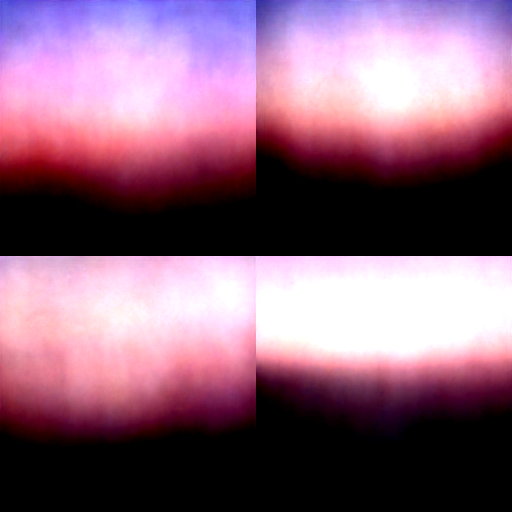


Step 10 of 50:


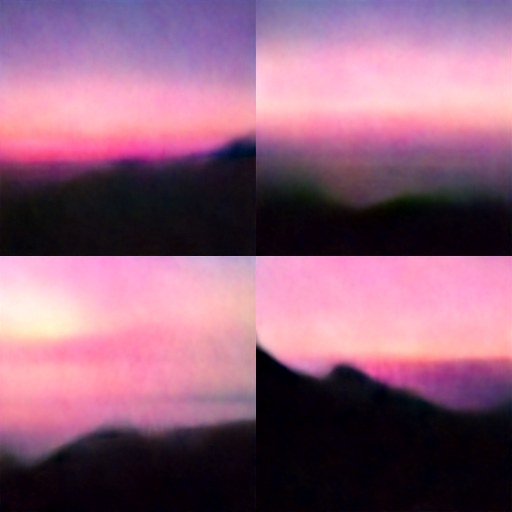


Step 20 of 50:


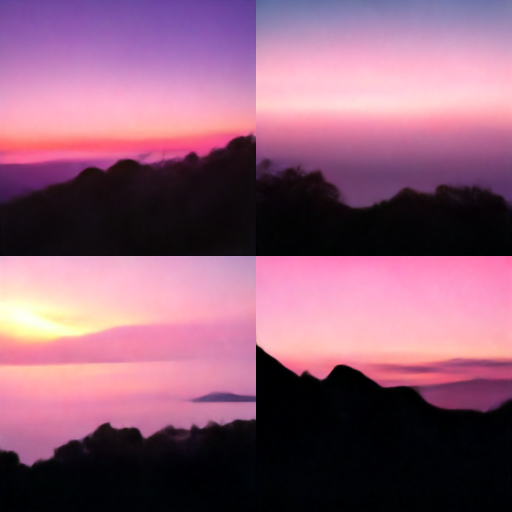


Step 30 of 50:


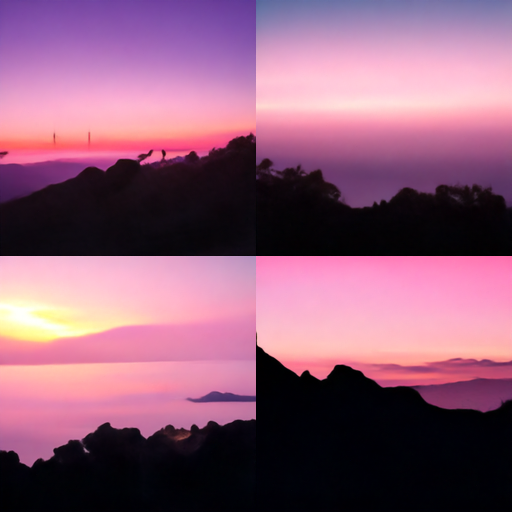


Step 40 of 50:


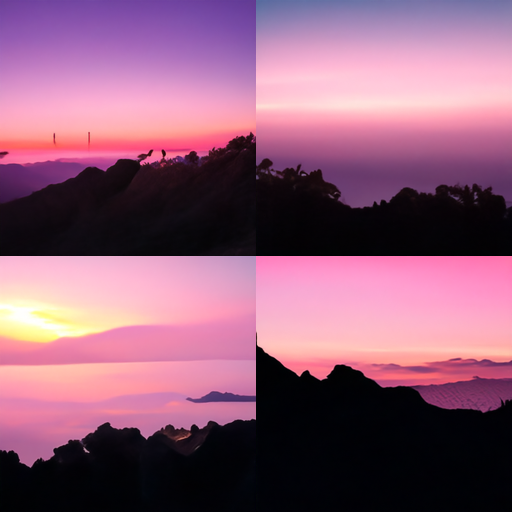


Done!


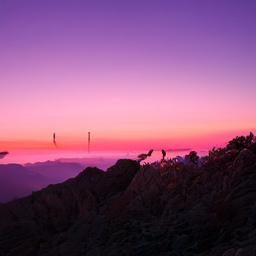

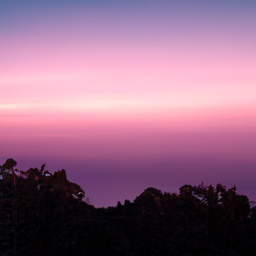

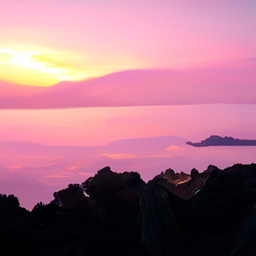

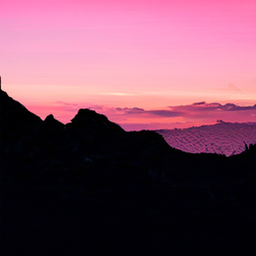

In [28]:
target_embed = clip_model.encode_text(clip.tokenize(prompt)).float().cuda()


def cfg_model_fn(x, t):
    """The CFG wrapper function."""
    n = x.shape[0]
    x_in = x.repeat([2, 1, 1, 1])
    t_in = t.repeat([2])
    clip_embed_repeat = target_embed.repeat([n, 1])
    clip_embed_in = torch.cat([torch.zeros_like(clip_embed_repeat), clip_embed_repeat])
    v_uncond, v_cond = model(x_in, t_in, clip_embed_in).chunk(2, dim=0)
    v = v_uncond + (v_cond - v_uncond) * weight
    return v


def display_callback(info):
    if info['i'] % display_every == 0:
        nrow = math.ceil(info['pred'].shape[0]**0.5)
        grid = tv_utils.make_grid(info['pred'], nrow, padding=0)
        tqdm.write(f'Step {info["i"]} of {steps}:')
        display.display(utils.to_pil_image(grid))
        tqdm.write(f'')


def run():
    gc.collect()
    torch.cuda.empty_cache()
    torch.manual_seed(seed)
    x = torch.randn([n_images, 3, side_y, side_x], device='cuda')
    t = torch.linspace(1, 0, steps + 1, device='cuda')[:-1]
    step_list = utils.get_spliced_ddpm_cosine_schedule(t)
    outs = sampling.plms_sample(cfg_model_fn, x, step_list, {}, callback=display_callback)
    tqdm.write('Done!')
    for i, out in enumerate(outs):
        filename = f'out_{i}.png'
        utils.to_pil_image(out).save(filename)
        display.display(display.Image(filename))


run()